## Task Description

Solve image classification with convolutional neural networks.

The images are collected from the food-11 dataset classified into 11
classes.

Training set: 280 * 11 labeled images + 6786 unlabeled images.

Validation set: 60 * 11 labeled images.

Testing set: 3347 images.

##  Packages



In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision.datasets import DatasetFolder
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingLR

In [4]:
myseed = 12345  # set seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Import Data
Food images of 11 classes
- Training set: 280 * 11 labeled images + 6786 unlabeled images
- Validation set: 60 * 11 labeled images
- Testing set: 3347 images


In [2]:
# download dataset
!sudo apt install megatools
!megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 148 kB of archives.
After this operation, 1,097 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 megatools amd64 1.9.98-1build2 [148 kB]
Fetched 148 kB in 0s (904 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package megatools.
(Reading database ... 155501 files and director

In [3]:
# unzip dataset
import zipfile
def un_zipFiles(path):
    files=os.listdir(path)
    for file in files:
        if file.endswith('.zip'):
            filePath=path+'/'+file
            zip_file = zipfile.ZipFile(filePath)
            for names in zip_file.namelist():
                zip_file.extract(names,path)
            zip_file.close() 
un_zipFiles('../content/')

## Load Dataset / Image Augmentation



In [7]:
train_tfm = transforms.Compose([
    # random crop
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    # random horizontal flip, prob = 0.5
    transforms.RandomHorizontalFlip(),
    # random noise
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4,hue=0.1),
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_tfm = transforms.Compose([
    # resize image to 256*256, then center crop to 224*224
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [8]:
# Define batch size for training, validation, and testing.
batch_size = 32

# Construct datasets.
train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)



In [9]:
# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## Image Example 

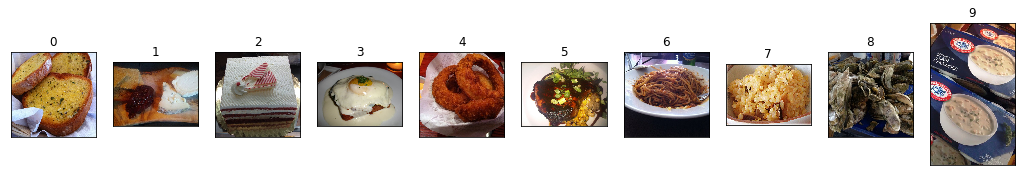

In [39]:
# Show some original images

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

plt.figure(figsize=(18, 18))

for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'food-11/training/labeled/0{i}/{i}_0.jpg'), title=i)

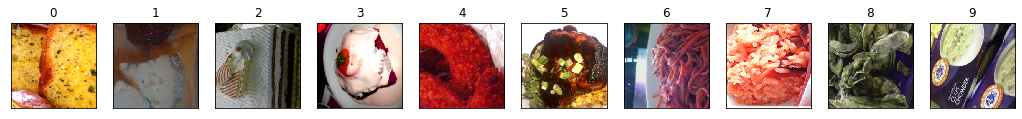

In [92]:
# Sample transformed Images

plt.figure(figsize=(18, 18))

sample_tfm = transforms.Compose([
    # random crop
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    # random horizontal flip, prob = 0.5
    transforms.RandomHorizontalFlip(),
    # random noise
    transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2,hue=0.1),
    transforms.ToTensor(),

    ])

for i in range(10):
  img = Image.open(f'food-11/training/labeled/0{i}/{i}_0.jpg')
  img = sample_tfm(img)
  img = img.T
  plt.subplot(2, 10, i+1)
  fig = no_axis_show(img, title=i)

## **Model**

resnext50 from pytorch vision

In [68]:
def model(num_classes, use_pretrained=True):
    """
    Load model from pytorch.

    Args:
        num_classes: number of classification classes.
        use_pretrained: load pretrained parameters.
    """
    model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    nn.init.xavier_uniform_(model_ft.fc.weight)

    return model_ft

## **Training**



### Semi-superviced Learning

In [62]:


class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]

def get_pseudo_labels(dataset, model, threshold=0.9):
    """
    Get pseudo labels for unlabeled data based on model inference.

    Args: 
        dataset: unlabeled dataset.
        model: inference model.
        threshold: softmax threshold, datas only get pseudo_labels
              when class probability is greater than threshold.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    softmax = nn.Softmax(dim=-1)

    idx = []
    labels = []

    for i, batch in enumerate(tqdm(data_loader)):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * batch_size + j)
                labels.append(int(torch.argmax(x)))

    model.train()
    print ("\nNew data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)
    return dataset

### Parameters and model

In [69]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = model(11).to(device)
model.device = device

In [70]:

# classification task criterion, measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer and cosine learning curve.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer,T_max=10)

# The number of training epochs.
n_epochs = 20

# Model path
model_path = '../content'

# Whether to do semi-supervised learning.
do_semi = True
threshold = 0.9

### Train

In [71]:
# Record bset accuracy in Dev set.
bst_acc = 0

# Iterate epochs.
for epoch in range(n_epochs):
    # Inference and combine pseudo dataset with labeled dataset
    if do_semi:
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set = get_pseudo_labels(unlabeled_set, model, threshold)
        # Construct a new dataset and a data loader for training.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # Record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()

        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    print("Epoch %d learning rate：%f" % (epoch+1,optimizer.param_groups[0]['lr']))
    scheduler.step()
    
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in evaluation mode before training.
    model.eval()

    # Record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        imgs, labels = batch

        with torch.no_grad():
          logits = model(imgs.to(device))

        
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # Save best model. 
    if valid_acc > bst_acc:
      bst_acc = valid_acc
      torch.save(model.state_dict(),f'{model_path}/model.pth')
      print(f'Save model with accuracy {bst_acc}')

100%|██████████| 213/213 [01:50<00:00,  1.92it/s]



New data:     0



100%|██████████| 97/97 [00:47<00:00,  2.02it/s]


Epoch 1 learning rate：0.000100
[ Train | 001/020 ] loss = 1.03622, acc = 0.66495


100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


[ Valid | 001/020 ] loss = 0.53230, acc = 0.81399
Save model with accuracy 0.8139880895614624


100%|██████████| 213/213 [01:52<00:00,  1.90it/s]



New data:  2878



100%|██████████| 187/187 [01:31<00:00,  2.04it/s]


Epoch 2 learning rate：0.000098
[ Train | 002/020 ] loss = 0.50939, acc = 0.83974


100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


[ Valid | 002/020 ] loss = 0.47178, acc = 0.85744
Save model with accuracy 0.8574405312538147


100%|██████████| 213/213 [01:50<00:00,  1.92it/s]



New data:  4160



100%|██████████| 227/227 [01:51<00:00,  2.04it/s]


Epoch 3 learning rate：0.000090
[ Train | 003/020 ] loss = 0.49134, acc = 0.85118


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


[ Valid | 003/020 ] loss = 0.39405, acc = 0.88780
Save model with accuracy 0.8877975940704346


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  4507



100%|██████████| 238/238 [01:56<00:00,  2.05it/s]


Epoch 4 learning rate：0.000079
[ Train | 004/020 ] loss = 0.42014, acc = 0.86927


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


[ Valid | 004/020 ] loss = 0.48159, acc = 0.87232


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  4507



100%|██████████| 238/238 [01:56<00:00,  2.05it/s]


Epoch 5 learning rate：0.000065
[ Train | 005/020 ] loss = 0.36557, acc = 0.88568


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


[ Valid | 005/020 ] loss = 0.35296, acc = 0.90536
Save model with accuracy 0.9053571820259094


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  4661



100%|██████████| 242/242 [01:58<00:00,  2.04it/s]


Epoch 6 learning rate：0.000050
[ Train | 006/020 ] loss = 0.29562, acc = 0.91046


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


[ Valid | 006/020 ] loss = 0.33173, acc = 0.90744
Save model with accuracy 0.9074404835700989


100%|██████████| 213/213 [01:50<00:00,  1.94it/s]



New data:  4809



100%|██████████| 247/247 [02:00<00:00,  2.04it/s]


Epoch 7 learning rate：0.000035
[ Train | 007/020 ] loss = 0.23563, acc = 0.92753


100%|██████████| 21/21 [00:06<00:00,  3.29it/s]


[ Valid | 007/020 ] loss = 0.30259, acc = 0.90893
Save model with accuracy 0.9089285731315613


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5019



100%|██████████| 254/254 [02:04<00:00,  2.05it/s]


Epoch 8 learning rate：0.000021
[ Train | 008/020 ] loss = 0.23956, acc = 0.93073


100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


[ Valid | 008/020 ] loss = 0.30036, acc = 0.92024
Save model with accuracy 0.9202381372451782


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5245



100%|██████████| 261/261 [02:07<00:00,  2.05it/s]


Epoch 9 learning rate：0.000010
[ Train | 009/020 ] loss = 0.21487, acc = 0.93637


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


[ Valid | 009/020 ] loss = 0.27809, acc = 0.91696


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5254



100%|██████████| 261/261 [02:07<00:00,  2.05it/s]


Epoch 10 learning rate：0.000002
[ Train | 010/020 ] loss = 0.19066, acc = 0.94409


100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


[ Valid | 010/020 ] loss = 0.27583, acc = 0.92619
Save model with accuracy 0.9261905550956726


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5267



100%|██████████| 261/261 [02:08<00:00,  2.03it/s]


Epoch 11 learning rate：0.000000
[ Train | 011/020 ] loss = 0.19238, acc = 0.94071


100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


[ Valid | 011/020 ] loss = 0.28939, acc = 0.92024


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5283



100%|██████████| 262/262 [02:08<00:00,  2.04it/s]


Epoch 12 learning rate：0.000002
[ Train | 012/020 ] loss = 0.18508, acc = 0.94538


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


[ Valid | 012/020 ] loss = 0.28979, acc = 0.92232


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5364



100%|██████████| 264/264 [02:09<00:00,  2.04it/s]


Epoch 13 learning rate：0.000010
[ Train | 013/020 ] loss = 0.18468, acc = 0.94465


100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


[ Valid | 013/020 ] loss = 0.29628, acc = 0.91935


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5330



100%|██████████| 263/263 [02:08<00:00,  2.04it/s]


Epoch 14 learning rate：0.000021
[ Train | 014/020 ] loss = 0.20088, acc = 0.93952


100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


[ Valid | 014/020 ] loss = 0.29098, acc = 0.90893


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5243



100%|██████████| 261/261 [02:07<00:00,  2.05it/s]


Epoch 15 learning rate：0.000035
[ Train | 015/020 ] loss = 0.21333, acc = 0.93574


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


[ Valid | 015/020 ] loss = 0.32951, acc = 0.91726


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5366



100%|██████████| 264/264 [02:10<00:00,  2.03it/s]


Epoch 16 learning rate：0.000050
[ Train | 016/020 ] loss = 0.26126, acc = 0.91981


100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


[ Valid | 016/020 ] loss = 0.31994, acc = 0.92470


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5259



100%|██████████| 261/261 [02:07<00:00,  2.05it/s]


Epoch 17 learning rate：0.000065
[ Train | 017/020 ] loss = 0.29087, acc = 0.91338


100%|██████████| 21/21 [00:06<00:00,  3.30it/s]


[ Valid | 017/020 ] loss = 0.33515, acc = 0.90744


100%|██████████| 213/213 [01:50<00:00,  1.93it/s]



New data:  5076



100%|██████████| 255/255 [02:05<00:00,  2.04it/s]


Epoch 18 learning rate：0.000079
[ Train | 018/020 ] loss = 0.32131, acc = 0.90427


100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


[ Valid | 018/020 ] loss = 0.35701, acc = 0.89911


100%|██████████| 213/213 [01:50<00:00,  1.92it/s]



New data:  5036



100%|██████████| 254/254 [02:04<00:00,  2.04it/s]


Epoch 19 learning rate：0.000090
[ Train | 019/020 ] loss = 0.36084, acc = 0.89215


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


[ Valid | 019/020 ] loss = 0.41550, acc = 0.88750


100%|██████████| 213/213 [01:50<00:00,  1.92it/s]



New data:  4978



100%|██████████| 252/252 [02:03<00:00,  2.04it/s]


Epoch 20 learning rate：0.000098
[ Train | 020/020 ] loss = 0.33431, acc = 0.89662


100%|██████████| 21/21 [00:06<00:00,  3.33it/s]

[ Valid | 020/020 ] loss = 0.34108, acc = 0.90298


## Inference



In [72]:
# Load best model.
model.load_state_dict(torch.load(f'{model_path}/model.pth'))

model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):

    imgs, labels = batch

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

100%|██████████| 105/105 [00:40<00:00,  2.56it/s]


In [86]:
# result path
result_path = '../content'

# Save predictions into the file.
result = pd.DataFrame()
result['Id'] = range(0,len(test_set))
result['Category'] = predictions
result.to_csv( f'{result_path}/result.csv',index = False)